In [1]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../../astro_codes/')

In [2]:
gz_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')

In [3]:
mendel_masses = Table.read('../../fits/Simard+Mendel/mendel_masses.fits')
samples = Table.read('../../fits/SF_fits/samples.fits')
sparcfire = Table.read('../../fits/sparcfire/pitch_angles.fits')

In [4]:
import pandas as pd
#sparcfire_g_arcs = pd.read_csv('../../sparcfire_directories/g/g.galaxy_arcs.csv') # individual arc data
sparcfire_r_arcs = pd.read_csv('../../sparcfire_directories/r/r.galaxy_arcs.csv')

In [6]:
#sparcfire_g = Table.read('../../sparcfire_directories/main/sparcfire_g_matched.fits') # sparcfire data
sparcfire_r = Table.read('../../sparcfire_directories/r/r.galaxy_matched.fits') # sparcfire data

In [56]:
in_sparcfire_r = sparcfire_r['fit_state'] == 'OK'

In [57]:
in_sample = np.all([samples['in_spiral'],samples['axial_ok'],
                    mendel_masses['in_mass_limit'],sparcfire['P']>0,
                    in_sparcfire_r],
                   axis=0)

print('{} spiral galaxies!'.format(in_sample.sum()))

N_required = 500

spiral_range = np.arange(in_sample.sum())
np.random.seed(0)
spiral_indices = np.random.choice(spiral_range,N_required,replace=False)

gz_spirals = gz_data[in_sample]
dr7ids = gz_spirals['dr7objid_1'][spiral_indices]
dr8ids = gz_spirals['dr8objid'][spiral_indices]
urls = gz_spirals['jpeg_url'][spiral_indices]
spiral_table = Table(np.array([dr7ids,dr8ids,urls]).T,
                     names=('dr7id','dr8id','url'))

#spiral_table.write('spiral_ids.fits',overwrite=True)

2942 spiral galaxies!


In [58]:
from paramiko import SSHClient
from scp import SCPClient

ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect('bayonet-08.ics.uci.edu',username='zoo',password='GalaxyZoo2')
scp = SCPClient(ssh.get_transport())
ftp = ssh.open_sftp()
#files = ftp.listdir()

In [59]:
import matplotlib.image as mpimg

class ArcImage():
    
    def __init__(self,dr8id,ssh,scp,ftp,band='g'):
        self.dr8id = int(dr8id)
        self.band = band
        self.id_string = str(dr8id)
        self.id_suffix = self.id_string[-3:]
        self.remote_directory = ('/home/zoo/SpArcFiRe/SpArcFiRe/'
                                 '{}/{}/{}'.format(self.band,self.id_suffix,self.id_string))
        self.galaxy_directory = 'save_images/{}/{}'.format(self.band,self.id_string)
        self.band_directory = 'save_images/{}'.format(self.band)
        self.ssh = ssh
        self.scp = scp
        self.ftp = ftp
        
    def make_local(self):
        if os.path.isdir(self.band_directory) is False:
            os.mkdir(self.band_directory)
        if os.path.isdir(self.galaxy_directory) is False:
            os.mkdir(self.galaxy_directory)
        return None
    
    def download_remote_files(self,overwrite=False):
        _ = self.make_local()
        
        #remote_file = '{}/{}-C_preproc.png'.format(self.remote_directory,
                                                           #self.id_string)
        remote_file = '{}/{}-B_autoCrop.png'.format(self.remote_directory,
                                                    self.id_string)
        remote_arc_file = '{}/{}-J_logSpiralArcs-merged.png'.format(self.remote_directory,
                                                                    self.id_string)
        remote_input_file = '{}/{}-A_input.png'.format(self.remote_directory,
                                                       self.id_string)
        local_input_file = '{}/input_image.png'.format(self.galaxy_directory)
        local_file = '{}/cropped_image.png'.format(self.galaxy_directory)
        local_arc_file = '{}/output_image.png'.format(self.galaxy_directory)
        if (os.path.exists(local_file)):
            if overwrite is False:
                return local_input_file, local_file, local_arc_file
            else:
                [os.remove(file) for file in 
                 [local_file,local_arc_file,local_input_file]]
        scp.get(remote_file,local_file)
        scp.get(remote_arc_file,local_arc_file)
        scp.get(remote_input_file,local_input_file)
        return local_input_file, local_file, local_arc_file
    
    def select_arcs(self,arc_file,N_max=8):
        sparcfire_row_mask = arc_file['gxyName'] == self.dr8id
        arcs = arc_file[sparcfire_row_mask].sort_values('alenRank')
        arc_table = Table(arcs.as_matrix(),names=arcs.dtypes.index)
        if len(arc_table) > N_max:
            arc_table = arc_table[:N_max]
        return arc_table
    
    def display_image(self,ax):
        _, local_file, _ = self.download_remote_files(overwrite=False)
        image = mpimg.imread(local_file)
        ax.imshow(image,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        return local_file
    
    def draw_arcs(self,ax,arc_file,label=True,
                  **kwargs):
        plt.sca(ax)
        colors = ('red','blue','orange','magenta',
                  'limegreen','orangered','purple','cyan')
        arc_table = self.select_arcs(arc_file,N_max=8)
        N_arcs = len(arc_table)
        for n in range(N_arcs):
            arc_row = arc_table[n]
            theta_start = arc_row['math_initial_theta']
            theta_end = theta_start + arc_row['relative_theta_end']
            psi = arc_row['pitch_angle']*(2*math.pi/360)
            initial_radius = arc_row['math_initial_radius']
            r0 = initial_radius/np.exp(-psi*theta_start)
            thetas = np.linspace(theta_start,theta_end,1000)
            x = r0*(np.cos(thetas))*np.exp(-psi*thetas)#+128
            y = r0*(np.sin(thetas))*np.exp(-psi*thetas)#+128
            x_transformed = x + 128
            y_transformed = -y + 128
            plt.plot(x_transformed,y_transformed,
                     color=colors[n],**kwargs)
            plt.axis((0,256,256,0))
            if label is True:
                x_centre, y_centre = x_transformed[500], y_transformed[500]
                plt.text(x_centre,y_centre-5,'{}'.format(n+1),
                        color=colors[n],fontsize=20)
            
        return None

    def galaxy_level_params(self,galaxies_file):
        galaxy_row = galaxies_file['name'] == self.dr8id
        params = galaxies_file[galaxy_row]
        return params
        
    #files = self.ftp.listdir(self.remote_directory)
    #for file in files:

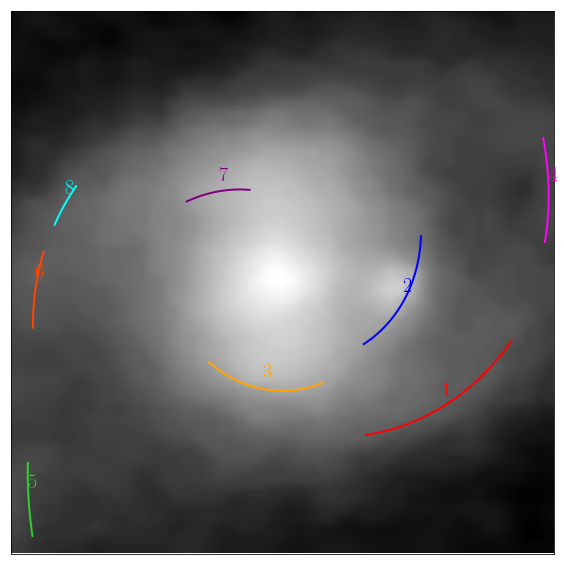

In [62]:
#fig, axarr = plt.subplots(20,2,figsize=(10,100))
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

for i,id_ in enumerate(dr8ids):
    fig.clf()
    ax = plt.subplot(111)
    arcimage = ArcImage(id_,ssh,scp,ftp,band='r')
    arcimage.display_image(ax)
    fig.savefig('panoptes_images/{}.jpg'.format(id_))
    #arcimage.display_image(ax)
    arcimage.draw_arcs(ax,sparcfire_r_arcs,linewidth=2)
    fig.savefig('panoptes_images/{}+arcs.jpg'.format(id_))
    #arcimage.draw_bar(axarr[1],sparcfire_g)
    
#fig.savefig('sdss_galaxies.jpg')

In [40]:
bad_ids = dr8ids[2:5]
#ArcImage(id0,ssh,scp,ftp).galaxy_level_params(sparcfire_r)

def get_bad_galaxy(dr8id):
    g_in, g_cropped, g_out = ArcImage(dr8id,ssh,scp,ftp,band='g').download_remote_files()
    r_in, r_cropped, r_out = ArcImage(dr8id,ssh,scp,ftp,band='r').download_remote_files()
    image_files = [g_in, g_cropped, g_out, r_in, r_cropped, r_out]
    labels = ['g input','g cropped','g output', 'r input','r cropped','r output']
    fig, axarr = plt.subplots(1,6,figsize=(20,3.3))
    for a, ax in enumerate(axarr):
        image = mpimg.imread(image_files[a])
        ax.imshow(image,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[a])
    return fig, axarr

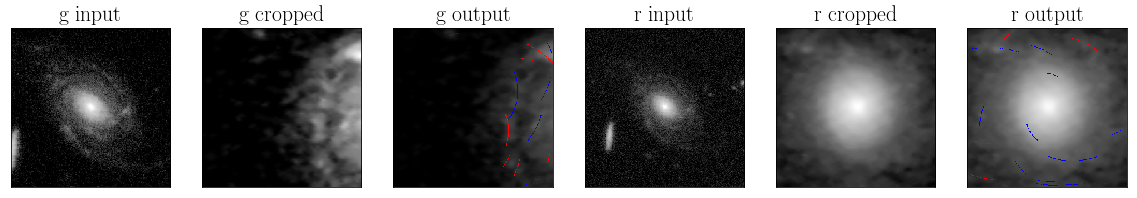

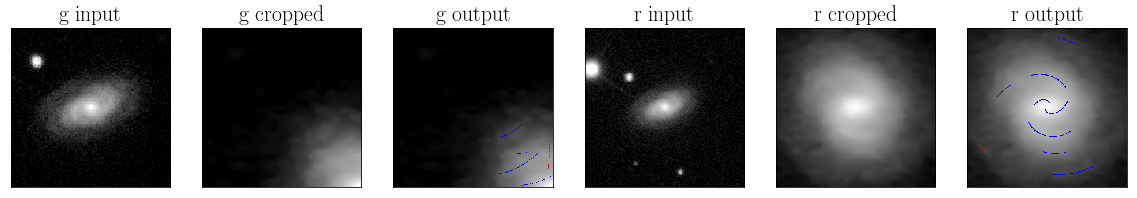

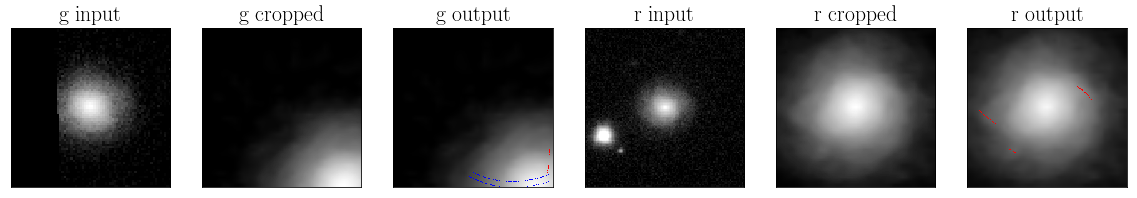

In [42]:
for id_ in bad_ids:
    _ = get_bad_galaxy(id_)